## Connected components

For all interactomes:
* Number of connected components
* Size of the largest connected component
* Relative size of the largest connected component
* Average size of the connected components
* Size of the smallest component
* Number of isolated nodes

For all pathways:
- Sizes of connected components for all pathways

In [1]:
import bisect

import networkx as nx
import pandas as pd
import seaborn as sns

import config
from config import GRAPHS_PATH
from lib.networks import get_interactomes

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

config.set_root_wd()


Working directory: c:\git\pathwayanalysisplatform\proteoformnetworks


In [2]:
interactomes = get_interactomes(GRAPHS_PATH)

In [3]:
import itertools


def getTuples(i):
    sizes = [len(c) / i.number_of_nodes() for c in sorted(nx.connected_components(i), key=len, reverse=True)]
    d = [(i.graph["method"], i.graph["level"], s) for s in sizes]
    return d


tuples = [getTuples(i) for i in interactomes]
data = list(itertools.chain.from_iterable(tuples))
data
df_cc = pd.DataFrame(data, columns=['Method', 'Level', 'Size'])
df_cc

,Method,Level,Size
0,no_sm,genes,0.81
1,no_sm,genes,0.01
2,no_sm,genes,0.00
3,no_sm,genes,0.00
4,no_sm,genes,0.00
...,...,...,...
13277,with_unique_sm,proteoforms,0.00
13278,with_unique_sm,proteoforms,0.00
13279,with_unique_sm,proteoforms,0.00
13280,with_unique_sm,proteoforms,0.00


c:\git\pathwayanalysisplatform\proteoformnetworks\venv\lib\site-packages\seaborn\axisgrid.py:643: UserWarning: Using the stripplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
c:\git\pathwayanalysisplatform\proteoformnetworks\venv\lib\site-packages\seaborn\axisgrid.py:643: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


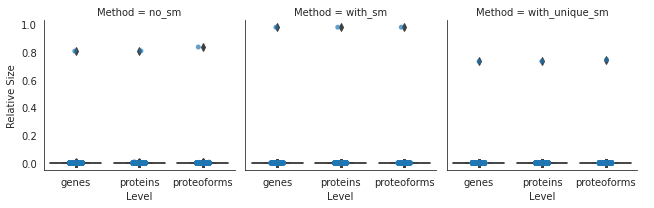

In [4]:
# Requires creating a dataframe with two columns
with sns.axes_style("white"):
    g = sns.FacetGrid(df_cc, col="Method")
g.map(sns.stripplot, "Level", "Size", alpha=.7)
g.map(sns.boxplot, "Level", "Size")
g.set_axis_labels("Level", "Relative Size")
g.add_legend()

In [5]:
# Number of connected components
# Size of the largest connected component
# Relative size of the largest connected component
# Average size of the connected components
# Size of the smallest component
# Number of isolated nodes

def getTuples(i):
    ccs_sizes = [len(c) for c in sorted(nx.connected_components(i), key=len, reverse=False)]
    num_ccs = len(ccs_sizes)

    return (
        i.graph["method"],
        i.graph["level"],
        num_ccs,
        ccs_sizes[-1],
        ccs_sizes[-1] / i.number_of_nodes(),
        sum(ccs_sizes) / len(ccs_sizes),
        ccs_sizes[0],
        0 if ccs_sizes[0] > 1 else bisect.bisect_left(ccs_sizes, 2, lo=0, hi=len(ccs_sizes))
    )


data = [getTuples(i) for i in interactomes]
columns = [
    'Method',
    'Level',
    'Number of connected components',
    'Size of largest connected component',
    'Relative size of largest connected component',
    'Average size of connected components',
    "Size of smallest connected component",
    "Number of isolated nodes"
]
df_interactomes = pd.DataFrame.from_records(data, columns=columns)
df_interactomes

,Method,Level,Number of connected components,Size of largest connected component,Relative size of largest connected component,Average size of connected components,Size of smallest connected component,Number of isolated nodes
0,no_sm,genes,1773,8869,0.81,6.19,1,1664
1,no_sm,proteins,1774,8966,0.81,6.24,1,1665
2,no_sm,proteoforms,1821,11984,0.84,7.85,1,1696
3,with_sm,genes,195,12692,0.98,66.32,1,166
4,with_sm,proteins,195,12790,0.98,66.83,1,166
5,with_sm,proteoforms,205,15962,0.98,79.32,1,173
6,with_unique_sm,genes,2427,28696,0.73,16.10,1,1152
7,with_unique_sm,proteins,2427,28793,0.73,16.14,1,1152
8,with_unique_sm,proteoforms,2465,31644,0.75,17.20,1,1159


In [6]:
from pathlib import Path
from config import METHODS, PATHWAY_GRAPHS_PATH
from config import LEVELS
from lib.networks import get_json_filename, create_pathway_interaction_network, read_graph
from lib.graph_database_access import get_pathways

columns_for_pathways = [
    'Pathway',
    'Method',
    'Level',
    'Relative size of largest connected component',
    'Average relative size of connected components',
    'Relative Size of smallest connected component',
    'Relative Number of isolated nodes'
]


def get_pathway_tuples(pathway, pathway_graph):
    ccs_sizes = [len(cc) for cc in sorted(nx.connected_components(pathway_graph), key=len, reverse=False)]
    rel_ccs_sizes = [size / pathway_graph.number_of_nodes() for size in ccs_sizes]

    return (
        pathway,
        pathway_graph.graph["method"],
        pathway_graph.graph["level"],
        rel_ccs_sizes[-1],
        sum(rel_ccs_sizes) / len(rel_ccs_sizes),
        rel_ccs_sizes[0],
        0 if ccs_sizes[0] > 1 else bisect.bisect_left(ccs_sizes, 2, lo=0, hi=len(ccs_sizes)) / len(ccs_sizes)
    )


data_pathways = []
for pathway in get_pathways()["stId"]:
    for method in METHODS:
        for level in LEVELS:
            filename = get_json_filename(level, method, PATHWAY_GRAPHS_PATH, pathway)
            if not Path(filename).exists():
                create_pathway_interaction_network(pathway, level, method, PATHWAY_GRAPHS_PATH)
            G = read_graph(filename)
            if G.number_of_nodes() > 0:
                data_pathways.append(get_pathway_tuples(pathway, G))

df_pathways = pd.DataFrame.from_records(data_pathways, columns=columns_for_pathways)
df_pathways

,Pathway,Method,Level,Relative size of largest connected component,Average relative size of connected components,Relative Size of smallest connected component,Relative Number of isolated nodes
0,R-HSA-9613829,no_sm,genes,1.00,1.00,1.00,0.00
1,R-HSA-9613829,no_sm,proteins,1.00,1.00,1.00,0.00
2,R-HSA-9613829,no_sm,proteoforms,1.00,1.00,1.00,0.00
3,R-HSA-9613829,with_sm,genes,1.00,1.00,1.00,0.00
4,R-HSA-9613829,with_sm,proteins,1.00,1.00,1.00,0.00
...,...,...,...,...,...,...,...
18403,R-HSA-917729,with_sm,proteins,1.00,1.00,1.00,0.00
18404,R-HSA-917729,with_sm,proteoforms,1.00,1.00,1.00,0.00
18405,R-HSA-917729,with_unique_sm,genes,1.00,1.00,1.00,0.00
18406,R-HSA-917729,with_unique_sm,proteins,1.00,1.00,1.00,0.00


In [7]:
grouped_multiple = df_pathways.groupby(['Method', 'Level']).agg(
    {
        'Relative size of largest connected component': ['mean'],
        'Average relative size of connected components': ['mean'],
        'Relative Size of smallest connected component': ['mean'],
        'Relative Number of isolated nodes': ['mean']
    })
grouped_multiple.columns = [
    'Avg. Rel. Size of LCC',
    'Avg. Rel. Size of CCs',
    'Avg. Rel. Size of SCC',
    'Avg. Rel. Number of isolated nodes'
]
grouped_multiple = grouped_multiple.reset_index()

grouped_multiple

,Method,Level,Avg. Rel. Size of LCC,Avg. Rel. Size of CCs,Avg. Rel. Size of SCC,Avg. Rel. Number of isolated nodes
0,no_sm,genes,0.79,0.70,0.66,0.37
1,no_sm,proteins,0.79,0.70,0.66,0.37
2,no_sm,proteoforms,0.79,0.70,0.65,0.36
3,with_sm,genes,0.85,0.77,0.73,0.20
4,with_sm,proteins,0.85,0.77,0.73,0.20
5,with_sm,proteoforms,0.84,0.77,0.72,0.20
6,with_unique_sm,genes,0.74,0.64,0.58,0.21
7,with_unique_sm,proteins,0.74,0.64,0.58,0.21
8,with_unique_sm,proteoforms,0.74,0.63,0.57,0.21
